# 0. Exploratory Data Analysis (EDA) for Snow Depth Prediction

In this EDA, we aim to understand the patterns and relationships in the historical weather and snow depth data for various ski resorts across the Alps. This analysis will guide us in selecting relevant features and building a robust model to predict snow depth, ultimately enhancing the service we provide to skiers.

We will follow an EDA plan, focusing on:

- Loading the Cleaned Data
- Analyzing Snow Depth Distribution Across Resorts
- Exploring Relationships Between Temperature and Snow Depth
- Assessing the Impact of Precipitation on Snow Depth
- Examining Seasonal Trends in Snow Depth
- Correlation Analysis Among Variables
- Additional Analyses as Needed

### 1. Loading imports and data
First, we'll load the cleaned and processed data into our environment for analysis.

In [5]:
import pandas as pd
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy.polynomial.polynomial import polyfit

### 1 (a). Import EDA modules

In [6]:
# Determine the project root directory (assuming the notebook is in the 'notebooks' folder)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Updated sys.path:")
for path in sys.path:
    print(path)

from src.eda.visualization import (
    plot_boxplot,
    plot_violinplot,
    plot_scatter,
    plot_line,
    plot_correlation_heatmap,
    plot_pairplot,
    decompose_time_series,
    plot_autocorrelation
)
from src.eda.statistical_analysis import (
    calculate_correlation,
    perform_linear_regression,
    get_regression_coefficients
)

Updated sys.path:
/workspace/SkiSnow
/home/gitpod/.pyenv/versions/3.12.6/lib/python312.zip
/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12
/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/lib-dynload

/workspace/SkiSnow/venv/lib/python3.12/site-packages


### 1 (b). State root

In [7]:
processed_data_root = '../data/processed/cds'

### 1 (c). Load DataFrames

In [8]:
# Initialize an empty dictionary to store DataFrames
data_frames = {}

# Use glob to find all cleaned CSV files in the processed data directory
csv_files = glob.glob(os.path.join(processed_data_root, '**', '*_cleaned_*.csv'), recursive=True)

exclude_resorts = [
    'french_alps/chamonix',
    'french_alps/val_d_isere_tignes',
    'french_alps/les_trois_vallees',
    'swiss_alps/verbier'
]

for file_path in csv_files:
    # Extract country and resort from the file path
    parts = file_path.split(os.sep)
    country = parts[-3]
    resort = parts[-2]
    key = f"{country}/{resort}"

    if key in exclude_resorts:
        print(f"Excluding resort from EDA: {key}")
        continue  # Skip the excluded resorts
    
    # Load the DataFrame
    df = pd.read_csv(file_path)
    
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Store in the dictionary
    data_frames[key] = df
    print(f"Loaded data for {key}: {df.shape[0]} rows.")


Loaded data for austrian_alps/kitzbuhel: 11184 rows.
Loaded data for austrian_alps/solden: 12418 rows.
Loaded data for austrian_alps/st_anton: 12418 rows.
Loaded data for italian_alps/cortina_d_ampezzo: 12015 rows.
Loaded data for italian_alps/sestriere: 12038 rows.
Loaded data for italian_alps/val_gardena: 12015 rows.
Loaded data for slovenian_alps/kranjska_gora: 12418 rows.
Loaded data for slovenian_alps/krvavec: 12418 rows.
Loaded data for slovenian_alps/mariborsko_pohorje: 12418 rows.
Loaded data for swiss_alps/st_moritz: 12009 rows.


### 1 (d). Combine DataFrames for Analysis

We'll create a single DataFrame combining all resorts for certain analyses.

In [9]:
# Add 'resort' and 'country' columns to each DataFrame and combine them
combined_data = []

for key, df in data_frames.items():
    country, resort = key.split('/')
    df['resort'] = resort
    df['country'] = country
    combined_data.append(df)

# Concatenate all DataFrames
all_data = pd.concat(combined_data, ignore_index=True)

# Update the list of resorts
included_resorts = all_data['resort'].unique()
print(f"Included resorts: {included_resorts}")

Included resorts: ['kitzbuhel' 'solden' 'st_anton' 'cortina_d_ampezzo' 'sestriere'
 'val_gardena' 'kranjska_gora' 'krvavec' 'mariborsko_pohorje' 'st_moritz']


## 2. Snow Depth Distribution Across Resorts

Hypothesis

Snow depth varies significantly across different resorts and countries due to geographical and climatic differences.

### 2(a) Summary Statistics

In [10]:
# Group by resort and calculate summary statistics
snow_depth_stats = all_data.groupby('resort')['snow_depth'].describe()
snow_depth_stats

,count,mean,std,min,25%,50%,75%,max
resort,,,,,,,,
cortina_d_ampezzo,7474.0,138.115868,233.776583,10.0,10.0,20.0,160.0,1610.0
kitzbuhel,11103.0,108.251824,223.798050,0.0,0.0,0.0,110.0,1570.0
kranjska_gora,8367.0,113.708569,139.983525,0.0,1.0,15.0,200.0,640.0
krvavec,7919.0,31.705140,67.463573,10.0,10.0,10.0,20.0,1280.0
mariborsko_pohorje,10737.0,27.240104,83.387475,0.0,10.0,10.0,20.0,1199.0
sestriere,8728.0,34.273144,96.754824,10.0,10.0,10.0,20.0,1509.0
solden,9443.0,44.592185,89.730593,10.0,10.0,20.0,41.0,2111.0
st_anton,12126.0,67.149101,156.807833,0.0,0.0,0.0,30.0,1500.0
st_moritz,9684.0,102.695271,237.949093,10.0,10.0,10.0,61.0,2499.0


### 2(b) Box Plots

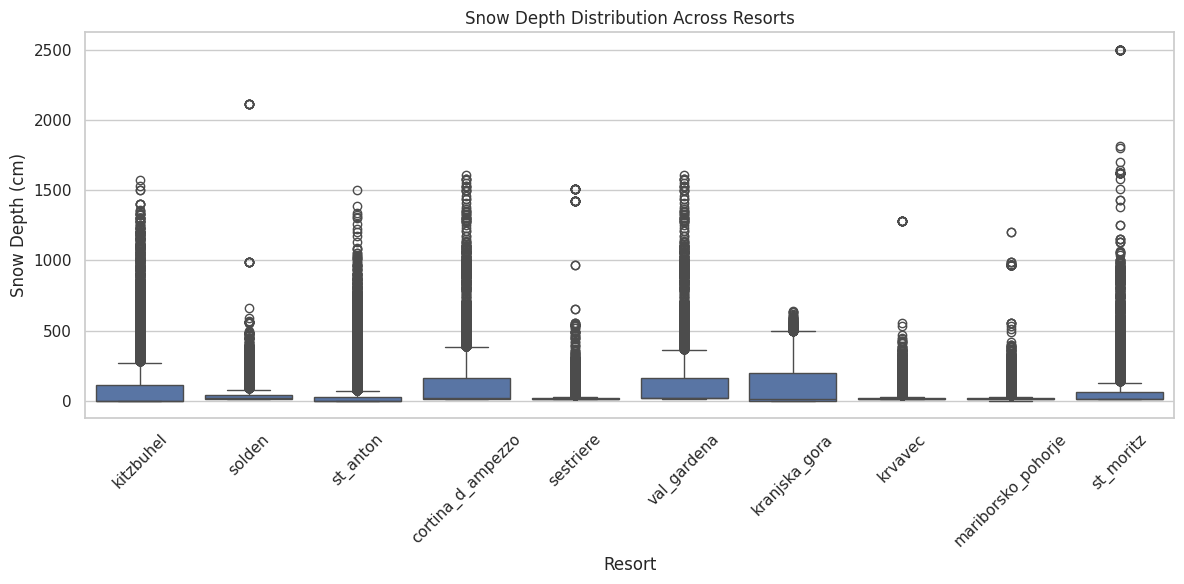

In [11]:
# Create a box plot for Snow Depth Distribution Across Resorts
plot_boxplot(
    df=all_data,
    x='resort',
    y='snow_depth',
    title='Snow Depth Distribution Across Resorts',
    xlabel='Resort',
    ylabel='Snow Depth (cm)',
    rotation=45
)

### 2(c) Violin Plots

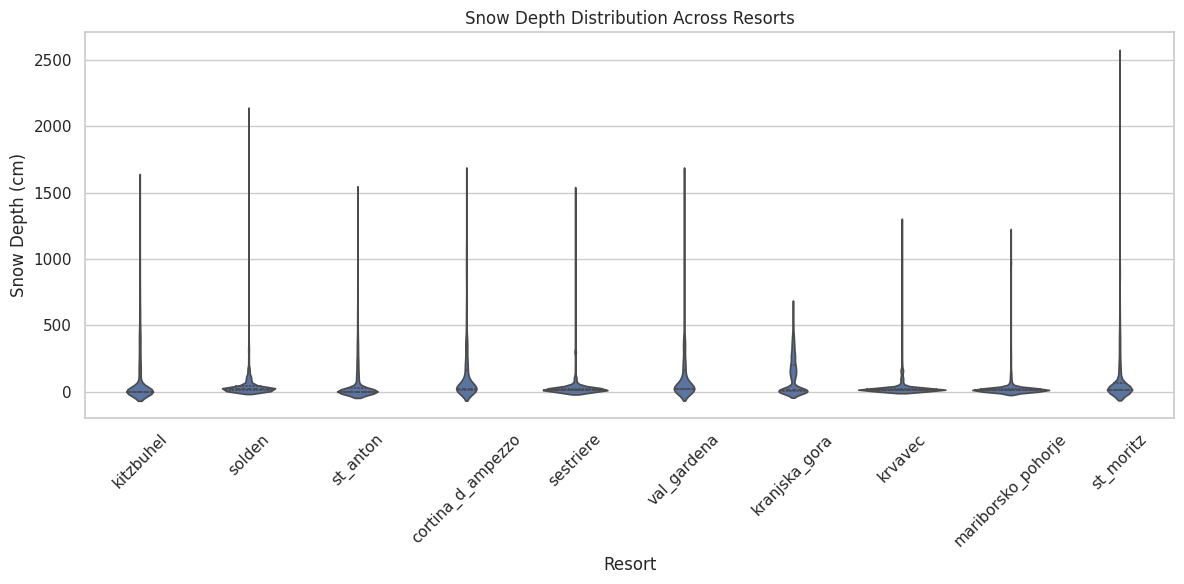

In [12]:
# Create a violin plot for Snow Depth Distribution Across Resorts
plot_violinplot(
    df=all_data,
    x='resort',
    y='snow_depth',
    title='Snow Depth Distribution Across Resorts',
    xlabel='Resort',
    ylabel='Snow Depth (cm)',
    rotation=45
)

## 3. Exploring Relationships Between Temperature and Snow Depth

Hypothesis:

Lower temperatures are associated with higher snow depths.
Understanding this relationship can help in predicting snow depth based on temperature forecasts.

### 3(a) Scatter Plots of Snow Depth vs. Temperature

Create scatter plots to visualize the relationship between snow depth and both minimum and maximum temperatures.

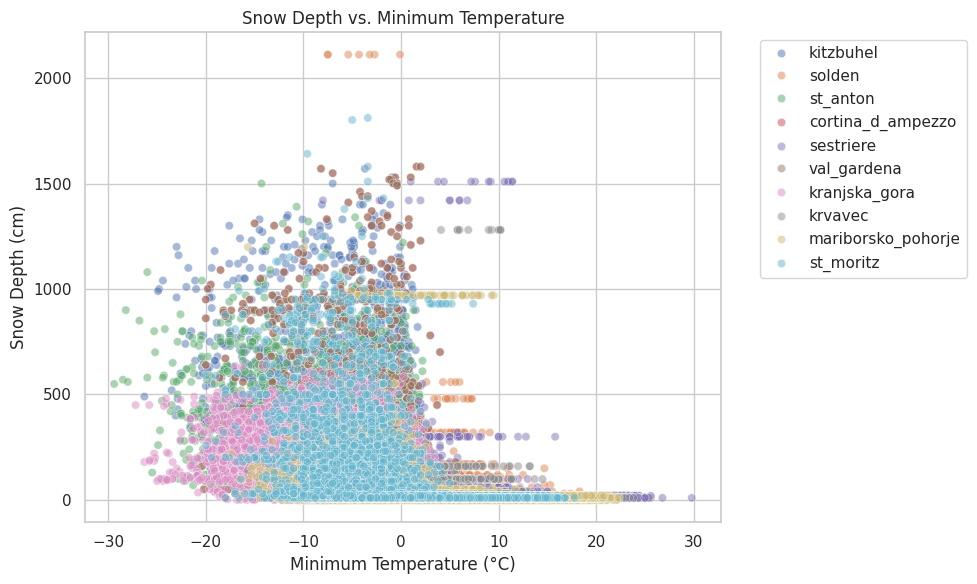

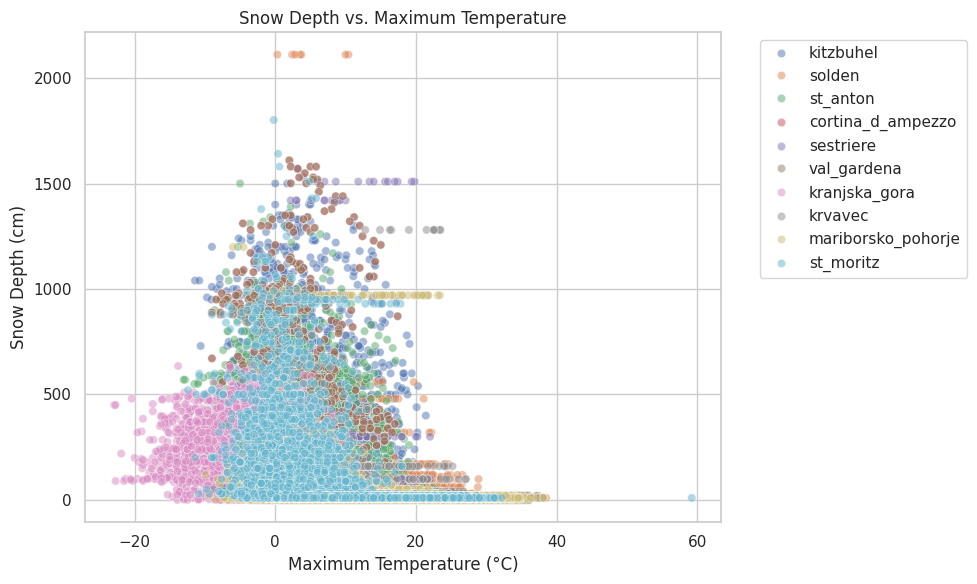

In [13]:
# Scatter plot of snow depth vs. temperature_min
plot_scatter(
    df=all_data,
    x='temperature_min',
    y='snow_depth',
    hue='resort',
    title='Snow Depth vs. Minimum Temperature',
    xlabel='Minimum Temperature (°C)',
    ylabel='Snow Depth (cm)',
    alpha=0.5
)

# Scatter plot of snow depth vs. temperature_max
plot_scatter(
    df=all_data,
    x='temperature_max',
    y='snow_depth',
    hue='resort',
    title='Snow Depth vs. Maximum Temperature',
    xlabel='Maximum Temperature (°C)',
    ylabel='Snow Depth (cm)',
    alpha=0.5
)

### Interpretation:

Negative Correlation Expected: We expect to see a negative correlation between temperature and snow depth, as higher temperatures may lead to snow melting.
Resort-Specific Patterns: The scatter plots can reveal if certain resorts have different patterns due to altitude or geographical location.

### 3(b) Correlation Coefficient

Compute the Pearson correlation coefficient to quantify the relationship.

In [14]:
# Calculate correlation coefficients
corr_temp_min = calculate_correlation(all_data, 'temperature_min', 'snow_depth')
corr_temp_max = calculate_correlation(all_data, 'temperature_max', 'snow_depth')

print(f"Correlation between temperature_min and snow_depth: {corr_temp_min:.2f}")
print(f"Correlation between temperature_max and snow_depth: {corr_temp_max:.2f}")

Correlation between temperature_min and snow_depth: -0.45
Correlation between temperature_max and snow_depth: -0.42


### Interpretation:

- Interpretation of Correlation Coefficients
- Correlation between Temperature Min and Snow Depth: -0.45
    Value Interpretation:

    The correlation coefficient of -0.45 indicates a moderate negative correlation between the minimum temperature and snow depth.
    This means that as the minimum temperature decreases (gets colder), the snow depth tends to increase.
    Conversely, warmer minimum temperatures are associated with lower snow depths.

- Correlation between Temperature Max and Snow Depth: -0.42
- Value Interpretation:

    Similarly, a correlation coefficient of -0.43 signifies a moderate negative correlation between the maximum temperature and snow depth.
    Higher maximum temperatures are associated with lower snow depths.
    This suggests that daytime temperatures also play a significant role in snow accumulation and melting.

### 3(c) Regression Analysis

Fit a simple linear regression model to further explore the relationship.

In [16]:
# Prepare data for temperature_min
data_min = all_data[['temperature_min', 'snow_depth']].dropna()
X_temp_min = data_min[['temperature_min']]
y_snow_depth_min = data_min['snow_depth']

# Prepare data for temperature_max
data_max = all_data[['temperature_max', 'snow_depth']].dropna()
X_temp_max = data_max[['temperature_max']]
y_snow_depth_max = data_max['snow_depth']

# Model for temperature_min
model_min = perform_linear_regression(X_temp_min, y_snow_depth_min)
coefficients_min = get_regression_coefficients(model_min)
print(f"Model Coefficients (temperature_min): Intercept = {coefficients_min['intercept']:.2f}, Slope = {coefficients_min['slope']:.2f}")

# Model for temperature_max
model_max = perform_linear_regression(X_temp_max, y_snow_depth_max)
coefficients_max = get_regression_coefficients(model_max)
print(f"Model Coefficients (temperature_max): Intercept = {coefficients_max['intercept']:.2f}, Slope = {coefficients_max['slope']:.2f}")

Model Coefficients (temperature_min): Intercept = 100.00, Slope = -9.07
Model Coefficients (temperature_max): Intercept = 160.15, Slope = -7.11


### Interpretation of the Regression Coefficients

For each model, the linear regression equation is of the form:

Snow Depth = Intercept + (Slope × Temperature)

#### Minimum Temperature

- Intercept (100.00 cm):

This represents the estimated snow depth when the minimum temperature is 0°C.

- Slope (-9.07 cm/°C):

For every 1°C increase in the minimum temperature, the snow depth decreases by approximately **9.07** cm.
Negative Slope: Confirms the inverse relationship between minimum temperature and snow depth.

#### Maximum Temperature

- Intercept (160.15cm):

Represents the estimated snow depth when the maximum temperature is 0°C.

- Slope (-7.11 cm/°C):

For every 1°C increase in the maximum temperature, the snow depth decreases by approximately 7.11 cm.
Negative Slope: Confirms the inverse relationship between maximum temperature and snow depth.

## 4. Assessing the Impact of Precipitation on Snow Depth

**Hypothesis:**

Increased precipitation leads to higher snow depth, especially when temperatures are below freezing.

### 4(a) Scatter Plot of Snow Depth vs. Precipitation

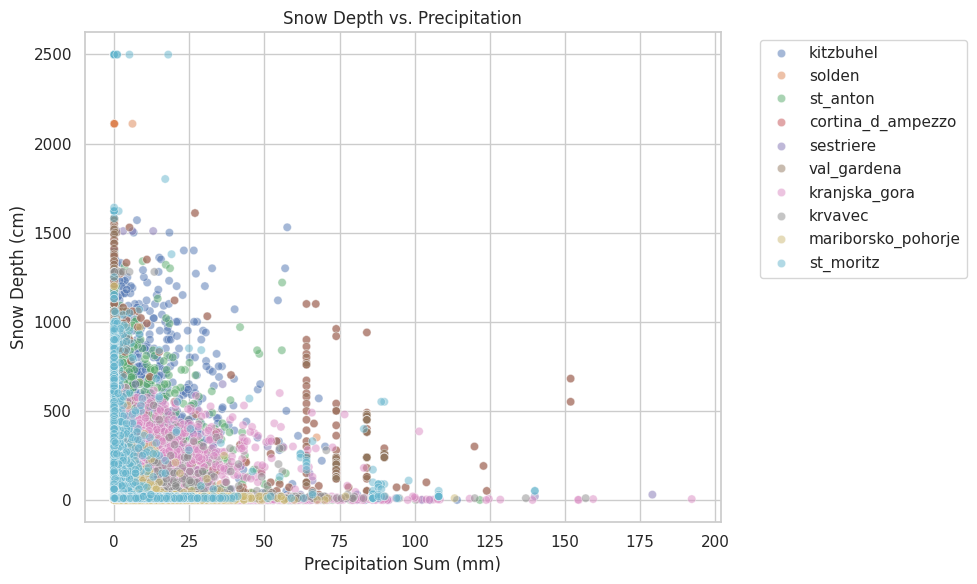

In [17]:
# Scatter plot of snow depth vs. precipitation_sum
plot_scatter(
    df=all_data,
    x='precipitation_sum',
    y='snow_depth',
    hue='resort',
    title='Snow Depth vs. Precipitation',
    xlabel='Precipitation Sum (mm)',
    ylabel='Snow Depth (cm)',
    alpha=0.5
)

### 4(b) Correlation Coefficient

In [18]:
# Calculate correlation coefficient
corr_precip = calculate_correlation(all_data, 'precipitation_sum', 'snow_depth')
print(f"Correlation between precipitation_sum and snow_depth: {corr_precip:.2f}")


Correlation between precipitation_sum and snow_depth: 0.02


#### Correlation between Precipitation Sum and Snow Depth

Value Interpretation:

A correlation coefficient of 0.02 indicates a very weak positive correlation between precipitation and snow depth.
This suggests that there is little to no linear relationship between the total daily precipitation and snow depth in the dataset.

### 4(c) Analysis During Freezing Temperatures

Since precipitation can fall as rain or snow depending on temperature, let's focus on days with temperatures below 0°C.

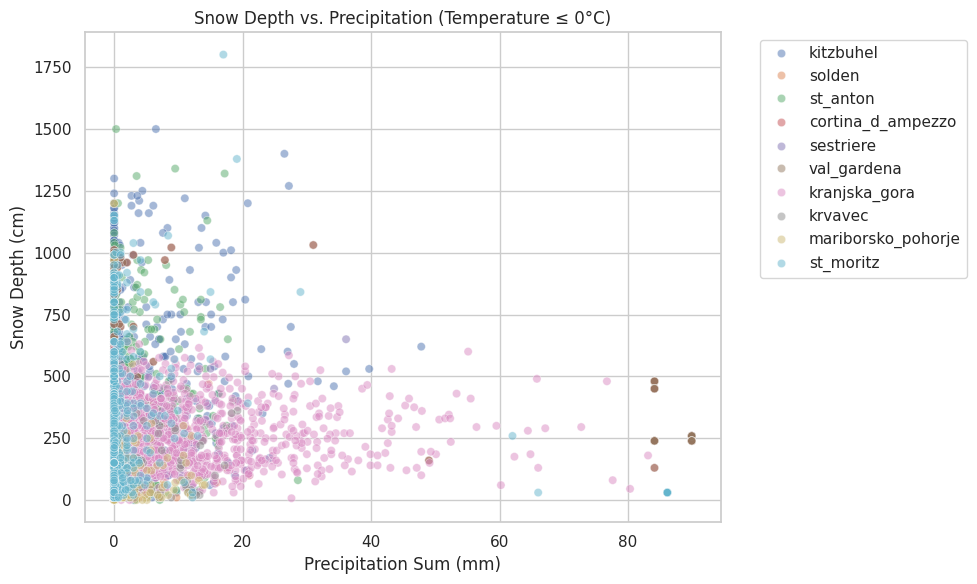

Correlation between precipitation_sum and snow_depth at freezing temperatures: 0.06


In [19]:
# Ensure 'is_operating_season' is in boolean format
all_data['is_operating_season'] = all_data['is_operating_season'].astype(bool)

# Filter data for temperatures below 0°C
freezing_data = all_data[
    (all_data['temperature_max'] <= 0) & 
    (all_data['is_operating_season'] == True)
]

# Scatter plot for freezing temperatures
plot_scatter(
    df=freezing_data,
    x='precipitation_sum',
    y='snow_depth',
    hue='resort',
    title='Snow Depth vs. Precipitation (Temperature ≤ 0°C)',
    xlabel='Precipitation Sum (mm)',
    ylabel='Snow Depth (cm)',
    alpha=0.5
)

# Correlation coefficient
corr_precip_freezing = calculate_correlation(freezing_data, 'precipitation_sum', 'snow_depth')
print(f"Correlation between precipitation_sum and snow_depth at freezing temperatures: {corr_precip_freezing:.2f}")


#### Interpretaiton

The correlation between precipitation_sum and snow_depth at freezing temperatures during the operating season is 0.06. This value indicates a very weak positive correlation, effectively suggesting that there is no meaningful linear relationship between precipitation and snow depth under these specific conditions.

### 5. Examining Seasonal Trends in Snow Depth

Hypothesis:

Snow depth varies seasonally, with peaks during the winter months.
Understanding seasonal patterns can help in temporal predictions.

### 5(a) Adding Month and Year Columns

In [20]:
# Add 'month' and 'year' columns
all_data['month'] = all_data['date'].dt.month
all_data['year'] = all_data['date'].dt.year

### 5(b) Average Snow Depth by Month

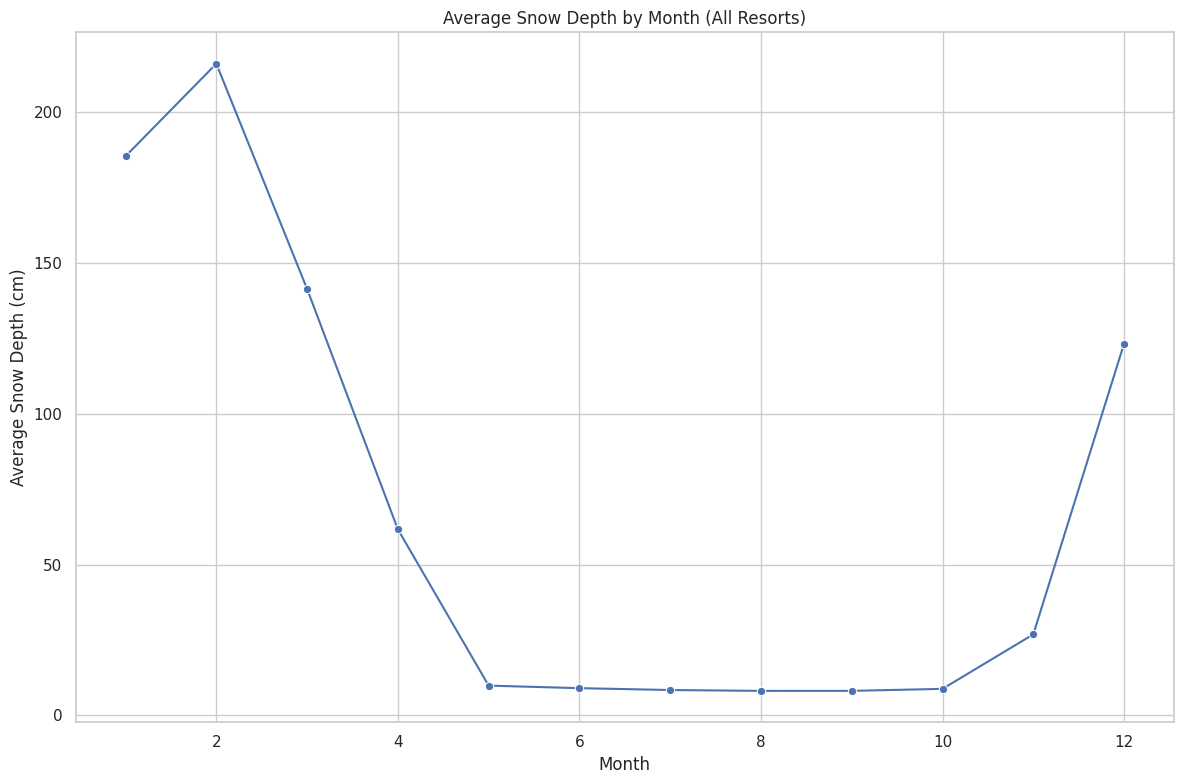

In [21]:
# Calculate average snow depth by month
monthly_snow_depth = all_data.groupby('month')['snow_depth'].mean().reset_index()


# Line plot for average snow depth by month
plot_line(
    df=monthly_snow_depth,
    x='month',
    y='snow_depth',
    title='Average Snow Depth by Month (All Resorts)',
    xlabel='Month',
    ylabel='Average Snow Depth (cm)'
)

### 5(c) Seasonal Trends by Resort

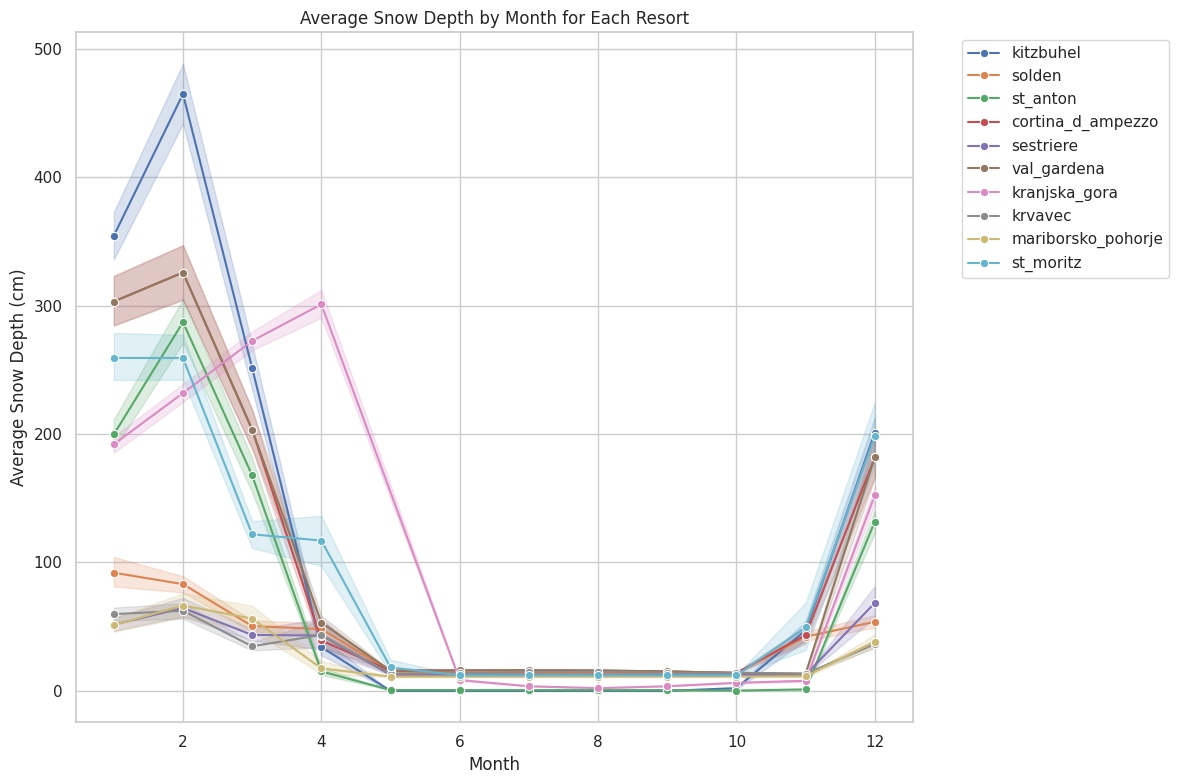

In [22]:
# Line plot for average snow depth by month for each resort
plot_line(
    df=all_data,
    x='month',
    y='snow_depth',
    hue='resort',
    title='Average Snow Depth by Month for Each Resort',
    xlabel='Month',
    ylabel='Average Snow Depth (cm)'
)

## 6. Correlation Analysis Among Variables

Hypothesis:

- Understanding the correlations among variables helps in feature selection for the predictive model.

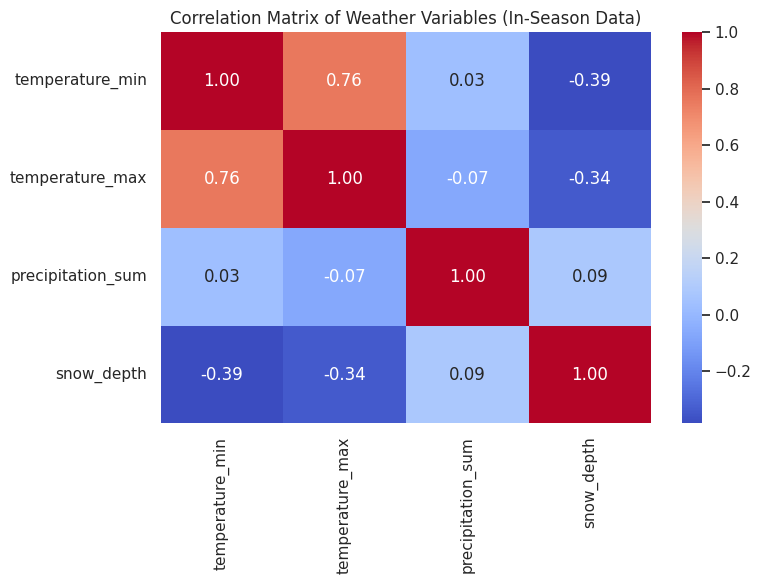

In [23]:
# Ensure 'is_operating_season' is of boolean type
all_data['is_operating_season'] = all_data['is_operating_season'].astype(bool)

# Filter data to include only in-season data
in_season_data = all_data[all_data['is_operating_season'] == True]

# Select relevant columns
correlation_columns = ['temperature_min', 'temperature_max', 'precipitation_sum', 'snow_depth']
correlation_data = in_season_data[correlation_columns].dropna()

# Compute and plot correlation matrix
plot_correlation_heatmap(
    df=correlation_data,
    title='Correlation Matrix of Weather Variables (In-Season Data)'
)

#### Interpretation: 

- Negative Correlation with Temperature: The strong negative correlation with temperature variables indicates that colder days are associated with deeper snow, a critical feature for models predicting snow depth.

- Low Correlation with Precipitation: The weak correlation with precipitation highlights that the type and intensity of precipitation are important to differentiate when predicting snow depth, as not all precipitation will contribute to snow.

- Multicollinearity: The strong correlation between minimum and maximum temperatures suggests potential multicollinearity.



### 7. Seasonal Decomposition

Since the skiing season spans several months, it's helpful to examine whether the relationships among variables change over the season.

/tmp/ipykernel_10471/24250770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_season_data['month'] = in_season_data['date'].dt.month


<Figure size 800x600 with 0 Axes>

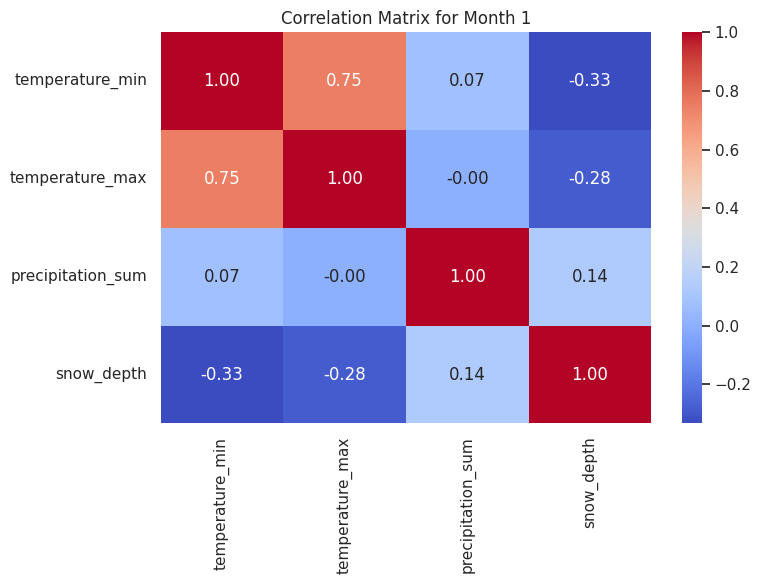

<Figure size 800x600 with 0 Axes>

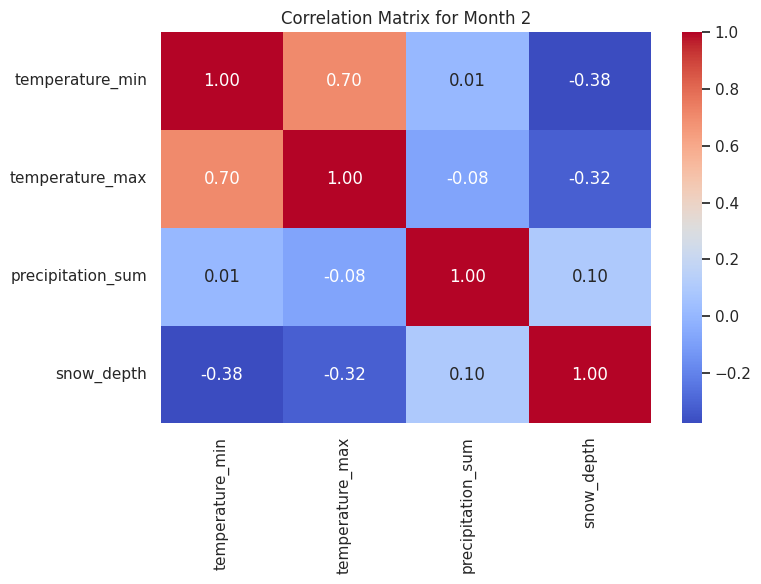

<Figure size 800x600 with 0 Axes>

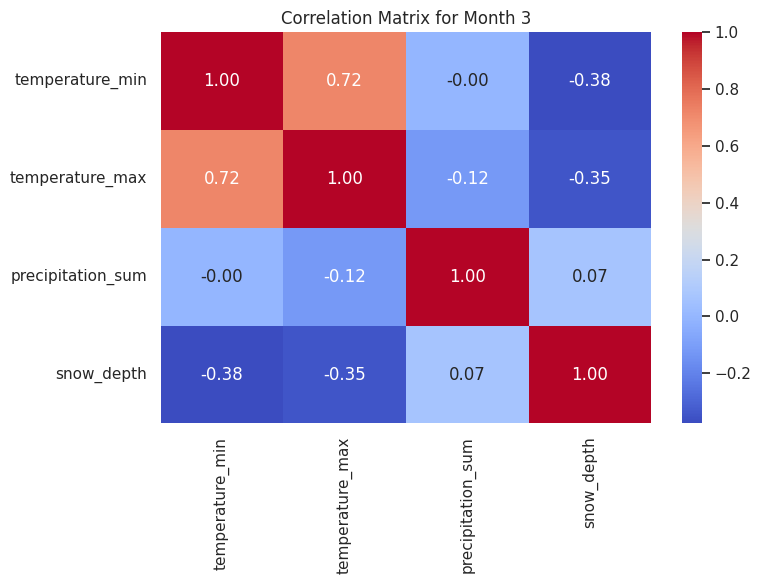

<Figure size 800x600 with 0 Axes>

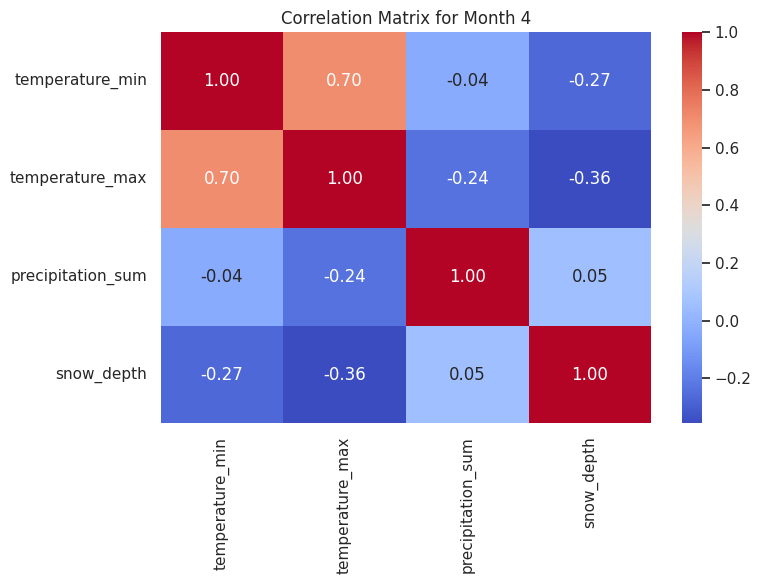

<Figure size 800x600 with 0 Axes>

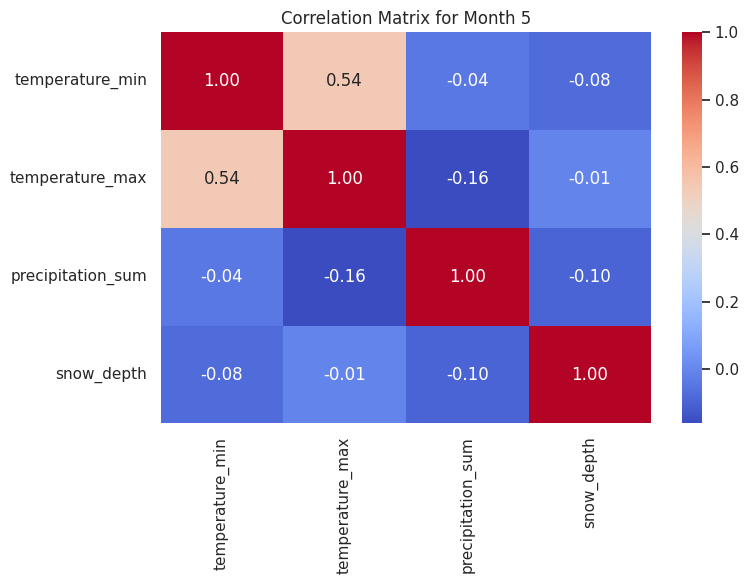

<Figure size 800x600 with 0 Axes>

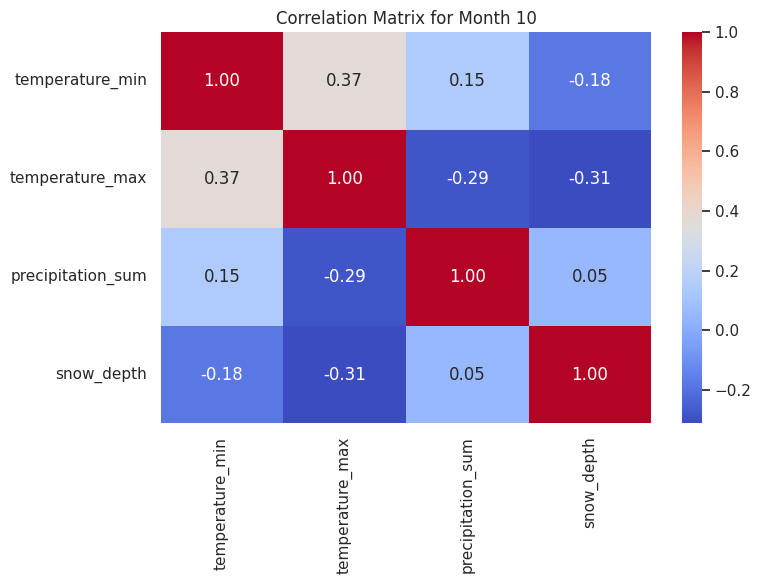

<Figure size 800x600 with 0 Axes>

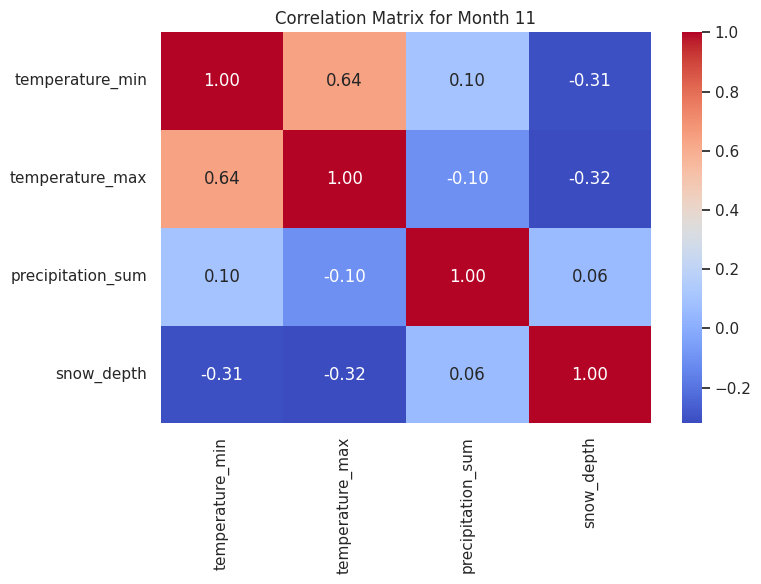

<Figure size 800x600 with 0 Axes>

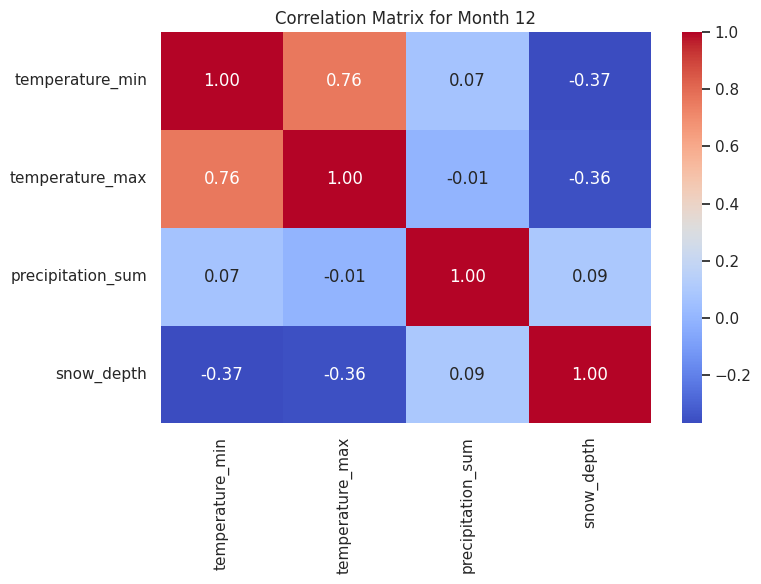

In [24]:
# Add 'month' as a categorical variable
in_season_data['month'] = in_season_data['date'].dt.month

# Compute correlation matrices for each month
for month in sorted(in_season_data['month'].unique()):
    monthly_data = in_season_data[in_season_data['month'] == month]
    correlation_data = monthly_data[correlation_columns].dropna()
    corr_matrix = correlation_data.corr()
    
    plt.figure(figsize=(8, 6))
    plot_correlation_heatmap(
        df=correlation_data,
        title=f'Correlation Matrix for Month {month}'
    )

### 7 (b) Pair Plot

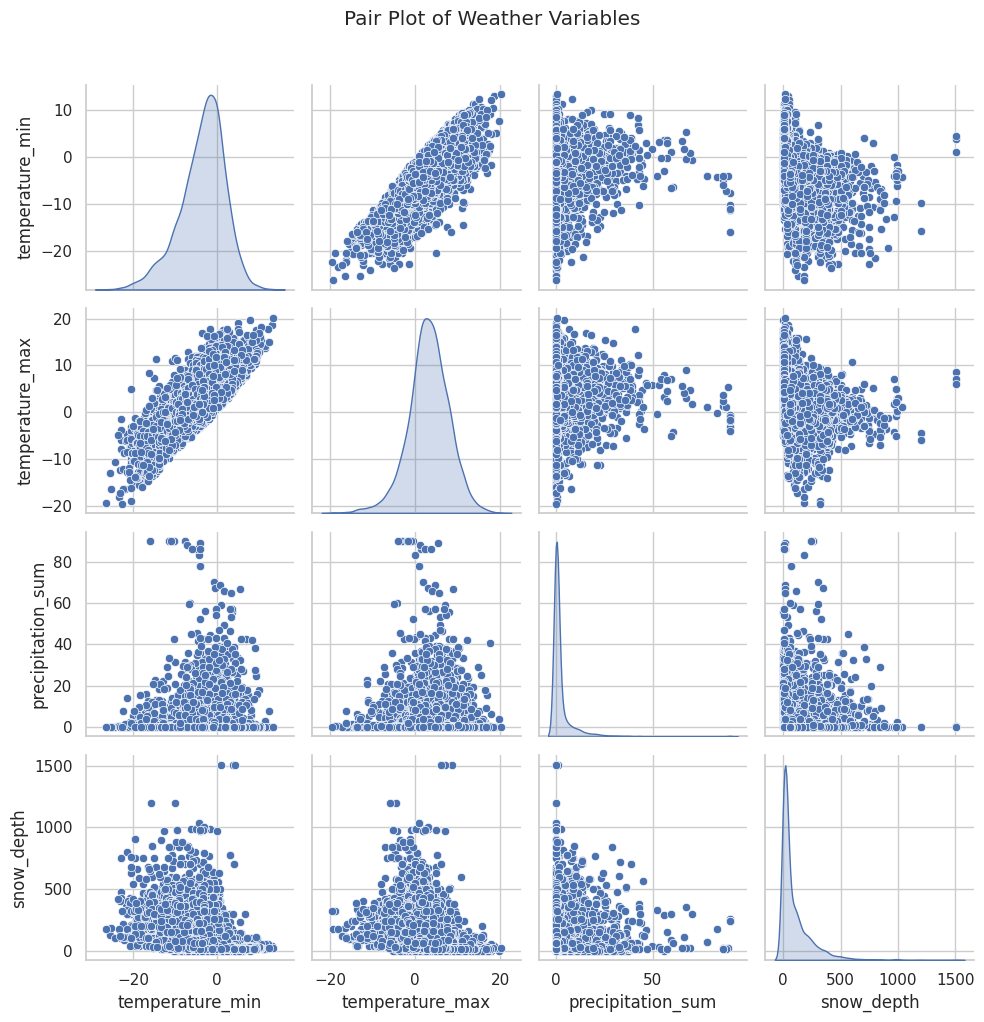

In [25]:
# Create a pair plot of weather variables
plot_pairplot(
    df=correlation_data,
    columns=correlation_columns,
    title='Pair Plot of Weather Variables'
)

## 8. Time Series Analysis

Hypothesis: Understanding trends, seasonality, and patterns over time to inform styles for predictive model.

Visualize Snow Depth Over Time:

Plotting snow depth over the years for each resort to identify long-term trends.
Detecting any patterns such as increasing or decreasing snow depths

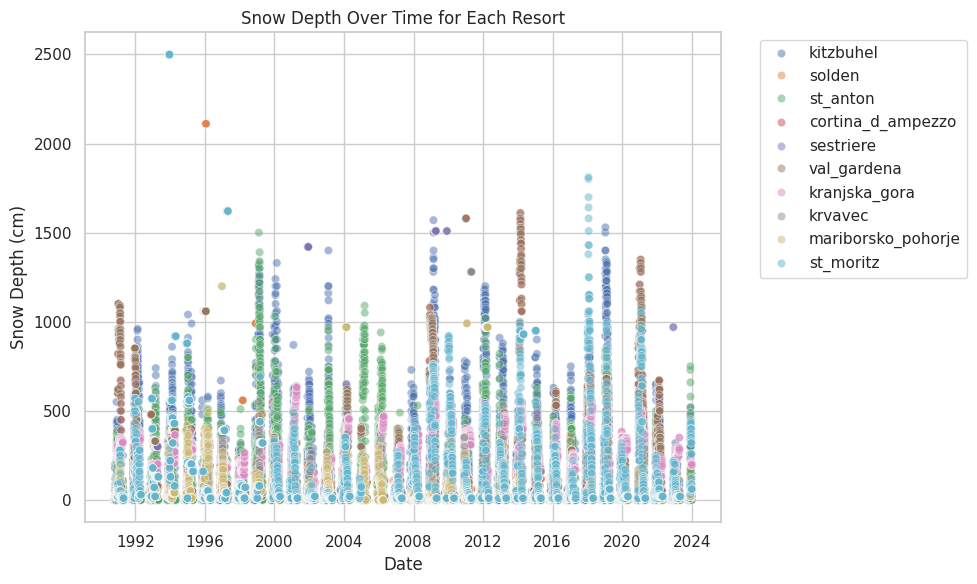

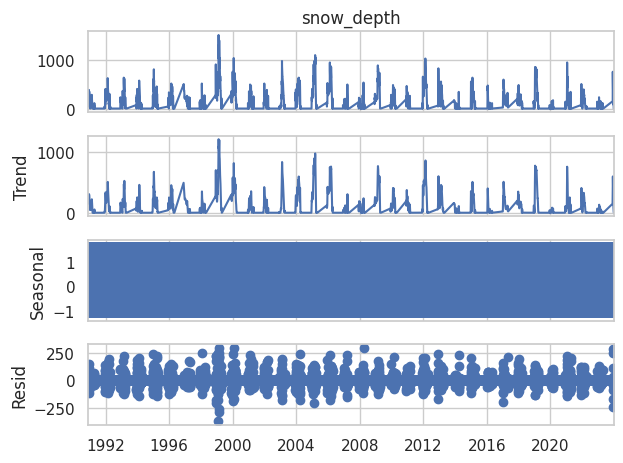

In [26]:
# Plot snow depth over time for each resort
plot_scatter(
    df=in_season_data,
    x='date',
    y='snow_depth',
    hue='resort',
    title='Snow Depth Over Time for Each Resort',
    xlabel='Date',
    ylabel='Snow Depth (cm)',
    alpha=0.5
)

# Decompose snow depth time series for a selected resort
resort_name = 'st_anton'
resort_data = in_season_data[in_season_data['resort'] == resort_name]
resort_data.set_index('date', inplace=True)
snow_depth_series = resort_data['snow_depth'].resample('D').mean().interpolate()

# Perform seasonal decomposition
decomposition = decompose_time_series(snow_depth_series, model='additive')

### 8 (a).  Calculate Autocorrelation Coefficients

<Figure size 1000x600 with 0 Axes>

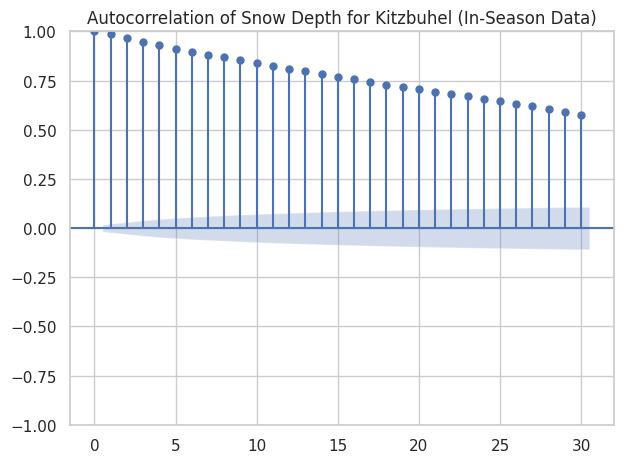

<Figure size 1000x600 with 0 Axes>

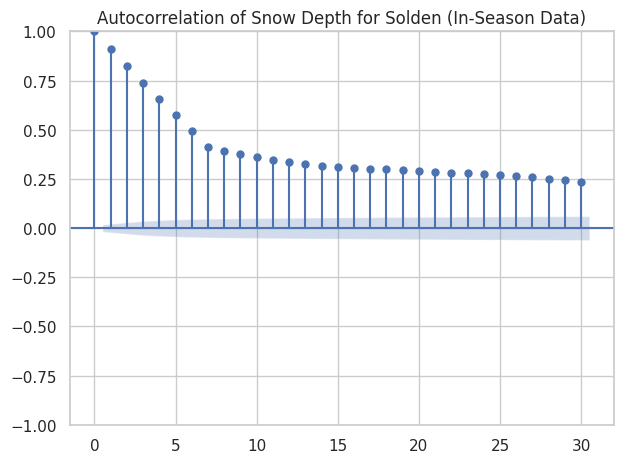

<Figure size 1000x600 with 0 Axes>

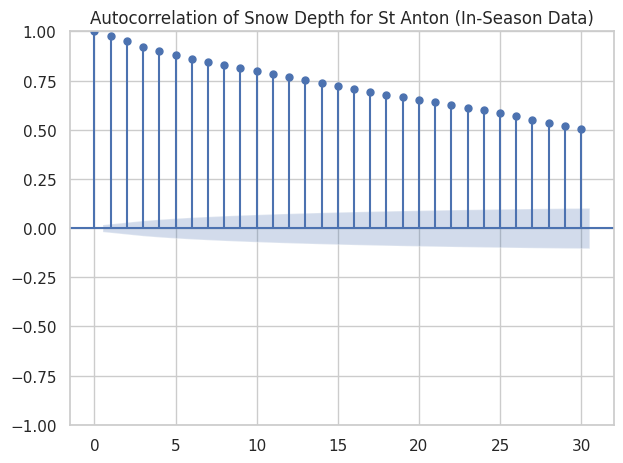

<Figure size 1000x600 with 0 Axes>

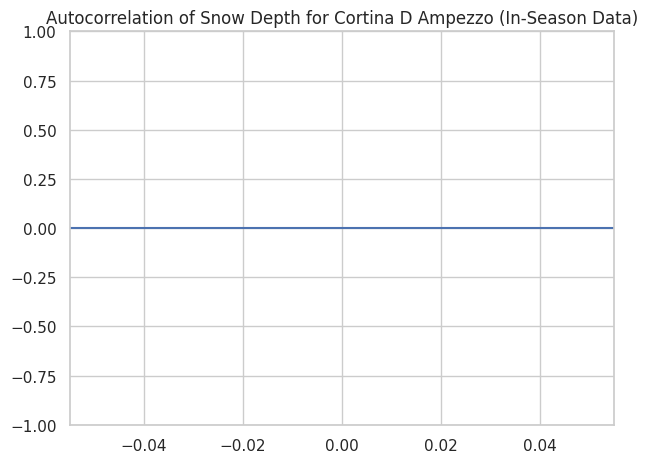

<Figure size 1000x600 with 0 Axes>

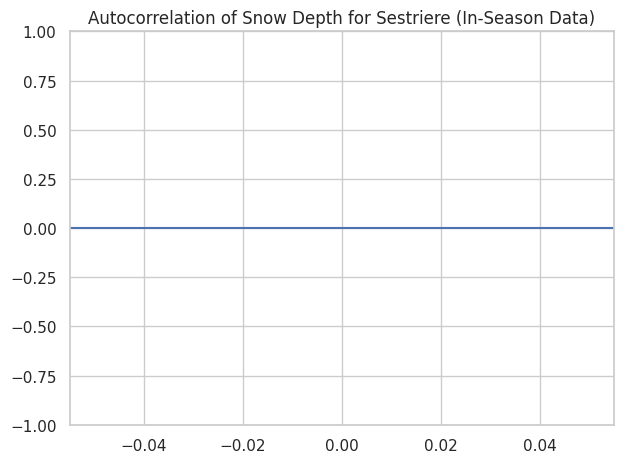

<Figure size 1000x600 with 0 Axes>

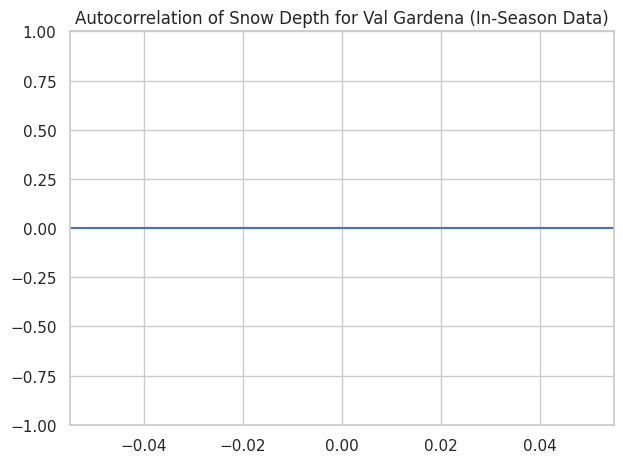

<Figure size 1000x600 with 0 Axes>

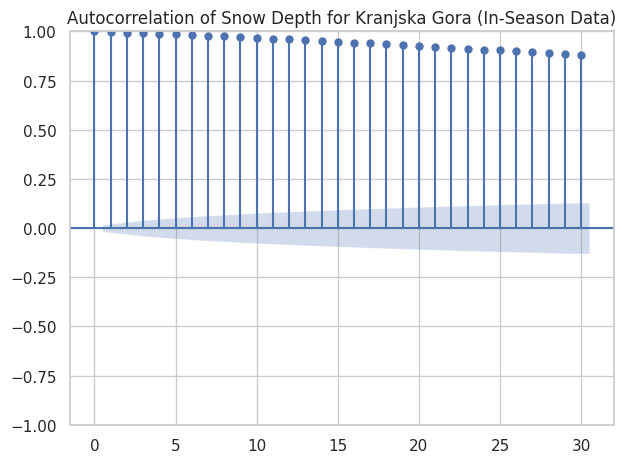

<Figure size 1000x600 with 0 Axes>

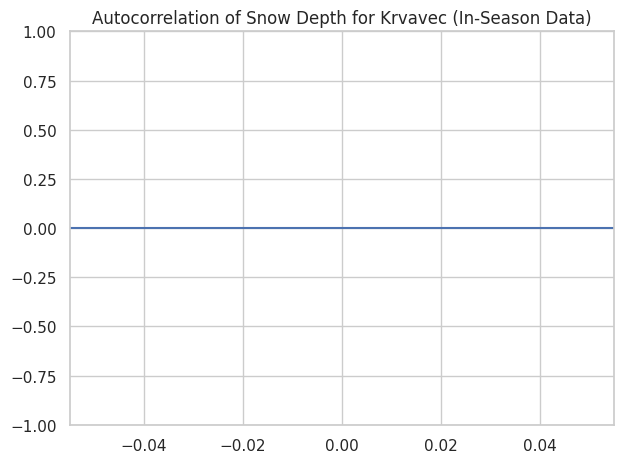

<Figure size 1000x600 with 0 Axes>

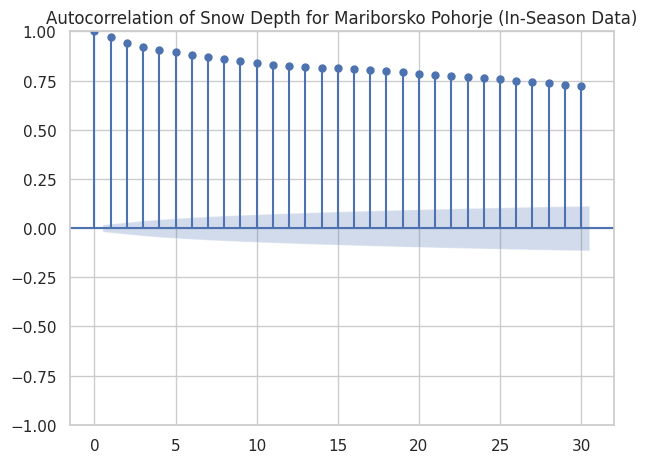

<Figure size 1000x600 with 0 Axes>

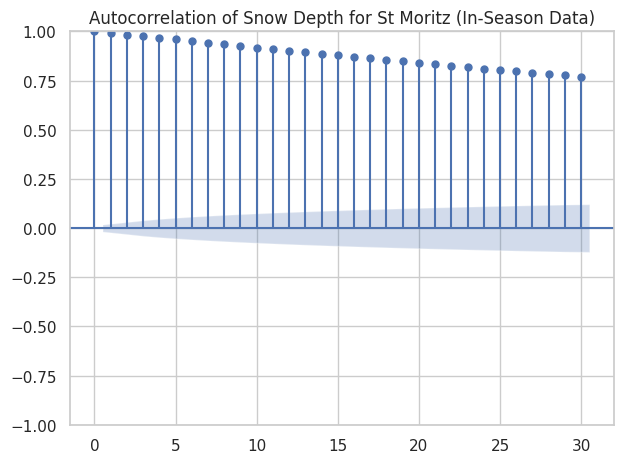

          date     resort  snow_depth  snow_depth_lag1  snow_depth_lag7
314 1990-11-11  kitzbuhel        20.0             70.0             50.0
315 1990-11-12  kitzbuhel        20.0             20.0            180.0
329 1990-11-26  kitzbuhel        30.0             20.0            200.0
330 1990-11-27  kitzbuhel        30.0             30.0            180.0
331 1990-11-28  kitzbuhel       100.0             30.0            120.0
332 1990-11-29  kitzbuhel        70.0            100.0             90.0
333 1990-11-30  kitzbuhel       100.0             70.0             70.0
334 1990-12-01  kitzbuhel       170.0            100.0             20.0
335 1990-12-02  kitzbuhel       140.0            170.0             20.0
336 1990-12-03  kitzbuhel       130.0            140.0             30.0


In [27]:
# List of resorts
resorts = in_season_data['resort'].unique()

for resort in resorts:
    # Filter data for the selected resort and in-season dates
    resort_data = in_season_data[in_season_data['resort'] == resort].copy()
    resort_data.set_index('date', inplace=True)
    snow_depth_series = resort_data['snow_depth'].asfreq('D').interpolate()
    
    if len(snow_depth_series.dropna()) > 30:
        # Plot ACF
        plot_autocorrelation(
            series=snow_depth_series,
            lags=30,
            title=f'Autocorrelation of Snow Depth for {resort.replace("_", " ").title()} (In-Season Data)'
        )
    else:
        print(f"Not enough data for {resort} to compute autocorrelation.")

# %%
# Filter in-season data where snow_depth > 0
non_zero_snow_data = in_season_data[in_season_data['snow_depth'] > 0].copy()

# Create lag features for snow depth
non_zero_snow_data['snow_depth_lag1'] = non_zero_snow_data.groupby('resort')['snow_depth'].shift(1)
non_zero_snow_data['snow_depth_lag7'] = non_zero_snow_data.groupby('resort')['snow_depth'].shift(7)

# Drop rows with NaN values in lag features
non_zero_snow_data = non_zero_snow_data.dropna(subset=['snow_depth_lag1', 'snow_depth_lag7'])

# Display the first few rows
print(non_zero_snow_data[['date', 'resort', 'snow_depth', 'snow_depth_lag1', 'snow_depth_lag7']].head(10))

#### 8 (b) Correlation Coefficients for Lag Features

In [28]:
# Calculate correlation coefficients
corr_lag1 = calculate_correlation(non_zero_snow_data, 'snow_depth', 'snow_depth_lag1')
corr_lag7 = calculate_correlation(non_zero_snow_data, 'snow_depth', 'snow_depth_lag7')

print(f"Correlation between snow_depth and snow_depth_lag1: {corr_lag1:.2f}")
print(f"Correlation between snow_depth and snow_depth_lag7: {corr_lag7:.2f}")


Correlation between snow_depth and snow_depth_lag1: 0.97
Correlation between snow_depth and snow_depth_lag7: 0.81


In [29]:
# Filter in-season data where snow_depth > 0
non_zero_snow_data = in_season_data[in_season_data['snow_depth'] > 0].copy()

# Create lag features for snow depth
non_zero_snow_data['snow_depth_lag1'] = non_zero_snow_data.groupby('resort')['snow_depth'].shift(1)
non_zero_snow_data['snow_depth_lag7'] = non_zero_snow_data.groupby('resort')['snow_depth'].shift(7)

# Drop rows with NaN values in lag features (if desired)
non_zero_snow_data = non_zero_snow_data.dropna(subset=['snow_depth_lag1', 'snow_depth_lag7'])

# Display the first few rows
print(non_zero_snow_data[['date', 'resort', 'snow_depth', 'snow_depth_lag1', 'snow_depth_lag7']].head(10))


          date     resort  snow_depth  snow_depth_lag1  snow_depth_lag7
314 1990-11-11  kitzbuhel        20.0             70.0             50.0
315 1990-11-12  kitzbuhel        20.0             20.0            180.0
329 1990-11-26  kitzbuhel        30.0             20.0            200.0
330 1990-11-27  kitzbuhel        30.0             30.0            180.0
331 1990-11-28  kitzbuhel       100.0             30.0            120.0
332 1990-11-29  kitzbuhel        70.0            100.0             90.0
333 1990-11-30  kitzbuhel       100.0             70.0             70.0
334 1990-12-01  kitzbuhel       170.0            100.0             20.0
335 1990-12-02  kitzbuhel       140.0            170.0             20.0
336 1990-12-03  kitzbuhel       130.0            140.0             30.0


In [30]:
# Calculate correlation coefficients
corr_lag1 = non_zero_snow_data['snow_depth'].corr(non_zero_snow_data['snow_depth_lag1'])
corr_lag7 = non_zero_snow_data['snow_depth'].corr(non_zero_snow_data['snow_depth_lag7'])

print(f"Correlation between snow_depth and snow_depth_lag1: {corr_lag1:.2f}")
print(f"Correlation between snow_depth and snow_depth_lag7: {corr_lag7:.2f}")


Correlation between snow_depth and snow_depth_lag1: 0.97
Correlation between snow_depth and snow_depth_lag7: 0.81


#### Interpretation

The high correlations observed between snow depth and its lagged features suggest that past snow depth values are strong predictors of current snow depth. Specifically:

- Lag 1 Correlation (0.97): This near-perfect correlation indicates that snow depth on a given day is very closely related to the snow depth on the previous day, showing strong temporal continuity.
- Lag 7 Correlation (0.81): The substantial weekly correlation suggests that snow depth retains a significant relationship with values from one week prior, reflecting the persistence of snow over time.